<a href="https://colab.research.google.com/github/oldevgeny/weather-forecast-project/blob/main/Weather_forecast_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weather forecast

## Settings

Install and import libraries

In [ ]:

import warnings
import logging
import collections
import datetime
import re
import csv
import sys
import time
import os
import gzip

warnings.filterwarnings('ignore')

!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install pandas
!pip install numpy
!pip install openpyxl
!pip install matplotlib
!pip install seaborn
!pip install plotly
!pip install sklearn
!pip install lightgbm
!pip install xgboost
!pip install rpy2
!pip install selenium
!pip install requests
!pip install python-telegram-bot==13.5
!pip install tornado==5.1.0


import requests

import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

from lightgbm import LGBMRegressor

from xgboost import XGBRegressor

from telegram import Bot
from telegram import Update
from telegram import ParseMode
from telegram import InlineKeyboardButton
from telegram import InlineKeyboardMarkup
from telegram import ReplyKeyboardRemove
from telegram.ext import CallbackContext
from telegram.ext import Updater
from telegram.ext import CommandHandler
from telegram.ext import MessageHandler
from telegram.ext import Filters
from telegram.ext import CallbackQueryHandler
from telegram.utils.request import Request
from telegram import KeyboardButton
from telegram import ReplyKeyboardMarkup

sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
current_dir = os.path.abspath(os.path.dirname('__file__'))

chrome_options = Options()
chrome_options.add_argument(f"download.default_directory={current_dir}")
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

%matplotlib inline
%load_ext rpy2.ipython

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/graph

## Data processing

### Advanced pandas, regular expresions and some graphics using Plotly

Load dataset

In [ ]:
df = pd.read_excel('table.xls')

For the purpose of weather prediction it's better to assume for missing values.
That they are similar to the previous or next day

In [ ]:
df = df.fillna(method='bfill')
df = df.fillna(method='ffill')

Check if there are any missing values left

In [ ]:
df.isnull().any().any()

False

Separate target and objects

In [ ]:
y = df['T']
X = df.drop(['T'], axis=1)

Picture of temperature distribution using only advanced pandas

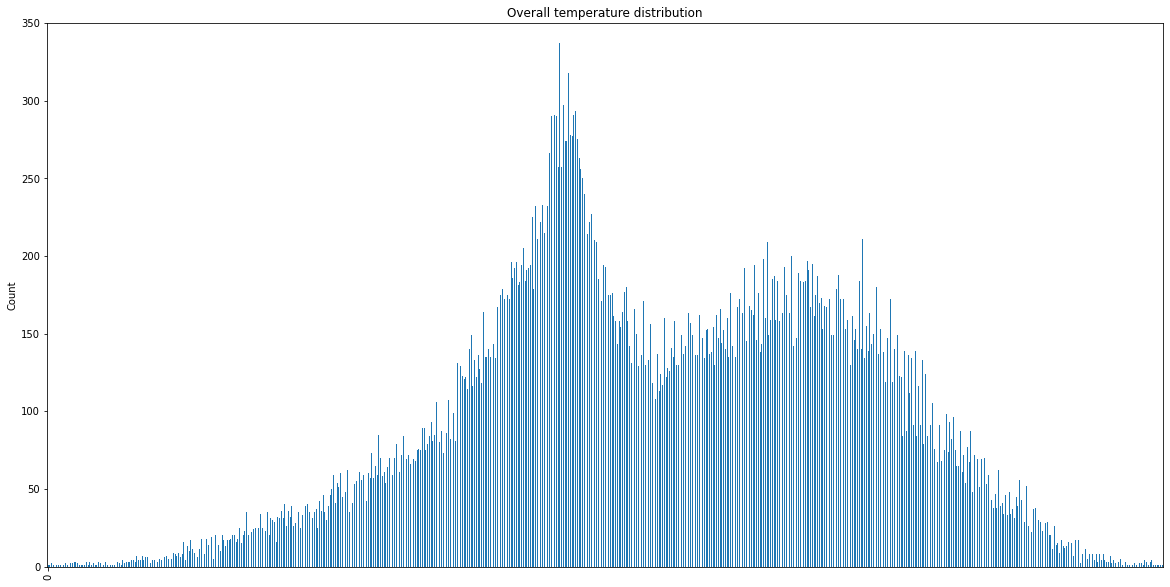

In [ ]:
y.value_counts(normalize=False)[y.value_counts(normalize=False).index.sort_values()].plot.bar(
    figsize=(20, 10), use_index=False, xlim=(0, 30), xticks=[0], ylim=(0, 350), xlabel='Temperature', ylabel='Count', 
    title='Overall temperature distribution', stacked=True
);

First column contains date - transform to DateTime format

In [ ]:
X['Local time in Moscow'] = pd.to_datetime(X['Local time in Moscow'])

Function that returns DataFrame with dates and temps for particular year and hour.

Using ***pandas*** methods and ***regular expresions***

In [ ]:
def getFrame(X, y, year, hour, name):
    mask_year = X['Local time in Moscow'].apply(
        lambda x: re.split('-', re.split(' ', str(x))[0])[0] == str(year)
    )
    mask_hour = X['Local time in Moscow'][mask_year].apply(
        lambda x: re.split(':', re.split(' ', str(x))[1])[0] == str(hour)
    )
    X_tmp = X['Local time in Moscow'][mask_year][mask_hour][::-1].apply(
        lambda x: re.split(' ', str(x))[0]
    )
    y_tmp = y[mask_year][mask_hour][::-1].to_numpy()
    frame = pd.DataFrame(
        {name:X_tmp, 'temperature':y_tmp}
    ).reset_index().drop(['index'], axis=1).sort_values(by=name)
    frame[name] = pd.to_datetime(frame[name])
    # in case year contains the 29th of February
    if frame[name].apply(lambda x: x.month == 2 and x.day == 29).sum():
        mask = (frame[name].apply(lambda x: x.month == 2 and x.day == 29))
        frame = frame[~mask]
    frame = frame.reset_index().drop(['index'], axis=1)
    return frame
new = getFrame(X, y, 2020, 12, 'year2020')

Visualization of temperature distribution using ***Plotly***

In [ ]:
fig = px.bar(new, x=new['year2020'], y=new['temperature'], 
             title='Temperature distribution over 2020', 
             labels={'temperature':'Temperature (°C)', 'year2020':'year 2020'})
fig.show()

### Data analysis with R (tidyverse and ggplot2 with tree layers (geom_*))

Prepare data to visuzlize with **ggplot2**

In [ ]:
years = range(2006, 2021)
data = getFrame(X, y, 2020, 12, 'date')
for i in years:
    tmp = getFrame(X, y, i, 12, 'date')
    data = pd.concat([data, tmp], axis=0)
data = data.reset_index().drop(['index'], axis=1)
data1 = data.copy()
data1['date'] = range(5828)
clf = LinearRegression()
clf.fit(data1.date.values.reshape(-1, 1), data1.temperature.values)
preds = clf.predict(data1.temperature.values.reshape(-1, 1))
data['reg'] = preds

Data selection with ***tidyverse*** and ***visualization with ggplot2 with tree layers (geom_*) using R language***


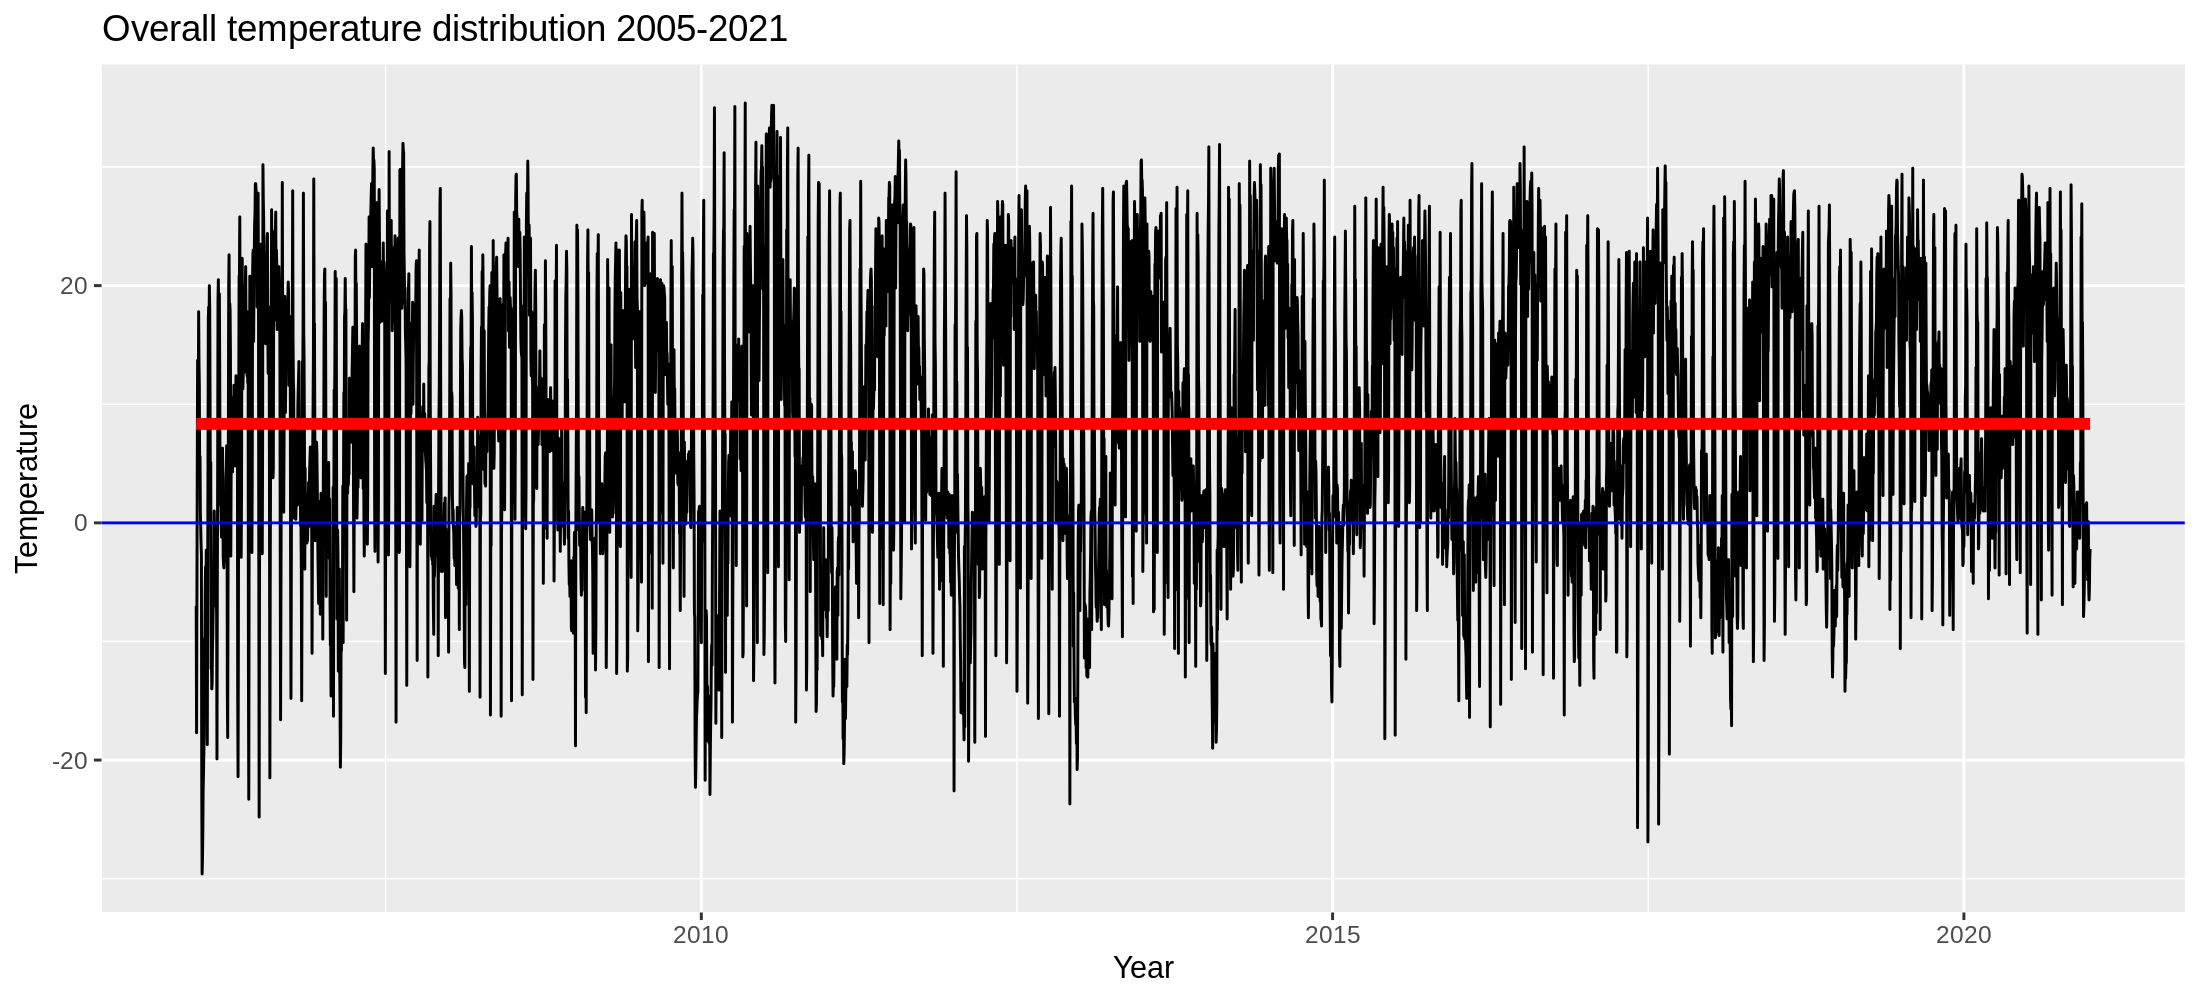

In [ ]:
%%R -i data -w 11 -h 5 --units in -r 200

library(tidyverse)
date <- data %>% select(date)
temperature <- data %>% select(temperature)
library(ggplot2)
ggplot(data) +
    geom_line(mapping = aes(x = date, y = temperature, color='black'), colour='black') +
    geom_hline(yintercept = 0, colour='blue') +
    geom_line(mapping = aes(x = date, y = reg), colour='red', size=2) +
    ggtitle('Overall temperature distribution 2005-2021') +
    xlab('Year') + ylab('Temperature') +
    guides(colour=guide_legend(label.position = "right", title="Text", title.position="left"))

### NumPy and Seaborn

Get separate column for day, month, hour of forecast

In [ ]:
X['day'] = X['Local time in Moscow'].apply(lambda x: x.day)
X['month'] = X['Local time in Moscow'].apply(lambda x: x.month)
X['hour'] = X['Local time in Moscow'].apply(lambda x: x.hour)

Don't need the column anymore - it contains id values irrelevant for model


In [ ]:
X = X.drop(['Local time in Moscow'], axis=1)

Get features table to select relevant


In [ ]:
matrix = np.array(['Col', 'Unique', 'Type'])
for col in X.columns:
    arr = np.array([col, X[col].unique().shape[0], X.dtypes[col]])
    matrix = np.vstack([matrix, arr])
features = pd.DataFrame(matrix[1:, :], columns=matrix[0, :])

Simple feature selection

In [ ]:
mask_unique = (features['Unique'] > 100).values
mask_type = (features['Type'] == 'object').values
mask = mask_unique * mask_type
trash_cols = features.values[mask][0][0]
X = X.drop([trash_cols], axis=1)

Create a data imputer from mean or most frequent values

In [ ]:
vec = list()
mask = (X.dtypes == 'object').values
for idx, col in enumerate(X.columns):
    if mask[idx]:
        vec.append(X[col].value_counts().index[0])
    else:
        vec.append(np.around(X[col].mean(), 0))
vec = np.array(vec)

In [ ]:
vec

array(['748.0', '762.0', '0.0', '76.0', 'Calm, no wind', '1.0', '12.0',
       '11.0', '100%.', 'Shower(s).',
       'Cloud covering more than 1/2 of the sky throughout the appropriate period.',
       '3.0', '10.0',
       'Stratocumulus other than Stratocumulus cumulogenitus.', '100%.',
       '600-1000', 'No Altocumulus, Altostratus or Nimbostratus.',
       'No Cirrus, Cirrocumulus or Cirrostratus.', '10', '2.0',
       'No precipitation', '12.0', 'Surface of ground moist.', '-1.0',
       'Compact or wet snow (with or without ice) covering less than one-half of the ground.',
       '1', '16.0', '6.0', '11.0'], dtype='<U84')

Get function for future data

In [ ]:
def convertData(file_path, vec):
    with gzip.open(file_path, 'rb') as f:
        df = pd.read_excel(f, header=6)
    df = df.fillna(method='bfill')
    df = df.fillna(method='ffill')
    y = df['T']
    X = df.drop(['T'], axis=1)
    X['Local time in Moscow'] = pd.to_datetime(X['Local time in Moscow'])
    X['day'] = X['Local time in Moscow'].apply(lambda x: x.day)
    X['month'] = X['Local time in Moscow'].apply(lambda x: x.month)
    X['hour'] = X['Local time in Moscow'].apply(lambda x: x.hour)
    X = X.drop(['Local time in Moscow', 'WW'], axis=1)
    if X.isnull().any().any():
        mask = X.isnull().any().values
        for idx, col in enumerate(X.columns):
            if mask[idx]:
                X[col] = X[col].fillna(vec[idx])
    return X, y

Get pairwise correlations between features and target


In [ ]:
mask_real = (X.dtypes != 'object').values
numeric_data = X[X.columns[mask_real]]
numeric_data['target'] = y
correlations = numeric_data.corr()

Visualization of correlations with ***Seaborn***

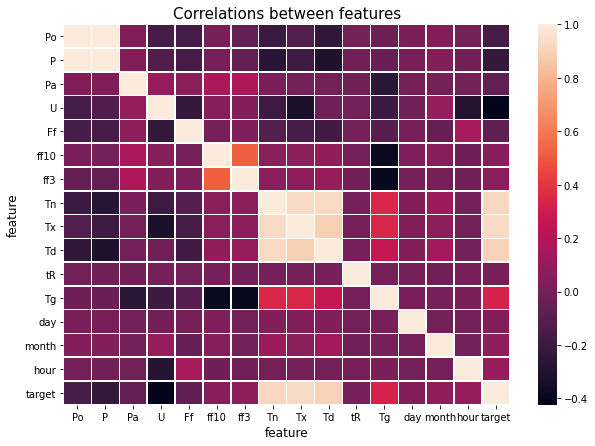

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(correlations, linewidth=0.5)
plt.title('Correlations between features', size=15)
plt.xlabel('feature', size=12)
plt.ylabel('feature', size=12)
plt.show()

### Machine learning

Split data to train and test future model


In [ ]:
np.random.seed(666)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Split real and categorical features


In [ ]:
mask = (X_train.dtypes == 'object').values
X_train_cat = X_train[X_train.columns[mask]]
X_test_cat = X_test[X_test.columns[mask]]
X_train_real = X_train[X_train.columns[~mask]]
X_test_real = X_test[X_test.columns[~mask]]

Normalize real features to get better results on linear models

In [ ]:
scaler = MinMaxScaler()
X_train_real = scaler.fit_transform(X_train_real)
X_test_real = scaler.transform(X_test_real)
encoder = OneHotEncoder()

Encoding categorical features to get digits with OHE


In [ ]:
encoder = OneHotEncoder()
X_train_cat = encoder.fit_transform(X_train_cat.astype(str))
X_test_cat = encoder.transform(X_test_cat.astype(str))

Join data back


In [ ]:
X_train = np.hstack([X_train_real, X_train_cat.todense()])
X_test = np.hstack([X_test_real, X_test_cat.todense()])

Get preprocesser for future data


In [ ]:
def preprocessData(df, mask, scaler, encoder):
    X_cat = df[df.columns[mask]]
    X_real = df[df.columns[~mask]]
    X_real = scaler.transform(X_real)
    X_cat = encoder.transform(X_cat.astype(str))
    X = np.hstack([X_real, X_cat.todense()])
    return X

Lack of correlations between features and target makes linear models ineffective


In [ ]:
np.random.seed(42)
clf = DecisionTreeRegressor(max_depth=18)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
accuracy_score(np.around(y_test), np.around(preds))

0.8089188715612405

Try **Random Forest**


In [ ]:
np.random.seed(42)
clf = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
accuracy_score(np.around(y_test), np.around(preds))

0.8854915016646224

Try ***leaf-wise gradient boosting***


In [ ]:
np.random.seed(42)
clf = LGBMRegressor(num_leaves=500, n_estimators=200, n_jobs=-1)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
accuracy_score(np.around(y_test), np.around(preds))

0.8712984054669703

Try **level-wise gradient boosting**

In [ ]:
np.random.seed(42)
clf = XGBRegressor(n_estimators=100, n_jobs=-1, nthread=-1, reg_lambda=1e-6, max_depth=13, objective='reg:squarederror')
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
accuracy_score(np.around(y_test), np.around(preds))

0.8803224110741195

Gather successful models together to increase final score


In [ ]:
np.random.seed(123)
estimators = [
    ('dt', DecisionTreeRegressor(max_depth=18)),
    ('rf', RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1)),
    ('lgbm', LGBMRegressor(num_leaves=500, n_estimators=200, n_jobs=-1)),
    ('xgb', XGBRegressor(n_estimators=100, n_jobs=-1, nthread=-1, reg_lambda=1e-6, max_depth=13, objective='reg:squarederror'))
]
clf = StackingRegressor(
    estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=50, n_jobs=-1))
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
accuracy_score(np.around(y_test), np.around(preds))

0.8910110390748204

Final function for prediction

In [ ]:
def predictionComparison(file_path, clf, mask, scaler, encoder, vec):
    X, y = convertData(file_path, vec)
    X['VV'] = X['VV'].astype(int)
    X['RRR'] = X['RRR'].astype(int)
    X = preprocessData(X, mask, scaler, encoder)
    preds = clf.predict(X)
    accuracy = accuracy_score(np.around(y), np.around(preds))
    return preds, accuracy

## Web scraping

### Selenium

#### rp5 parser for making prediction

Get .xml.gzip file with today weather data to current_dir

In [ ]:
try:
    browser = webdriver.Chrome(options=chrome_options)

    # WebDriver will wait 5 seconds for an element to appear on the page 
    # before throwing a NoSuchElementException
    browser.implicitly_wait(5)

    link = "https://rp5.ru/Weather_archive_in_Moscow"
    browser.get(link)

    button_1 = browser.find_element_by_css_selector("#tabSynopContainer .tabSynopOff")
    button_1.click()

    # if you want to get csv file:
    # csv_option = browser.find_element_by_css_selector(".menu-row3 td:nth-child(3) .input_radio")
    # csv_option.click()
    # utf_8_option = browser.find_element_by_css_selector(".menu-row4 td:nth-child(3) .input_radio")
    # utf_8_option.click()

    select_file_button = browser.find_element_by_css_selector(".menu-row4 .menu-row0 .download .inner")
    select_file_button.click()

    # tell Selenium to check for 10 seconds until the button becomes clickable
    download_file = WebDriverWait(browser, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, ".menu-row4 .menu-row0 .download #f_result a"))
        )
    download_file.click()
    file_name = download_file.get_attribute("href").split('/')[-1]
    
    time.sleep(2)
    file_path = os.path.join(current_dir, file_name)
finally:
    browser.quit()

##### Gismeteo parser to compare results 

In [ ]:
logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger('wb')

ParseResult = collections.namedtuple(
	'ParseResult',
	(
		'date',
		'time_0',
		'time_3',
		'time_6',
		'time_9',
		'time_12',
		'time_15',
		'time_18',
		'time_21',
	),
)

HEADERS = (
    "Date",
    "00:00",
    "03:00",
    "06:00",
    "09:00",
    "12:00",
    "15:00",
    "18:00",
    "21:00",
)

csv_path = os.path.join(current_dir, "data.csv")

td_date = datetime.datetime.now()

class Parser:

    def __init__(self):
        # avoid parser blocking
        self.session = requests.Session()
        self.session.headers = {
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36',
            'Accept-Language': 'ru',
        }
        self.result = []

    def load_page(self, page: int = None):
        # process site responses
        url = 'https://www.gismeteo.ru/weather-moscow-4368/tomorrow/'
        res = self.session.get(url=url)
        try:
            res.raise_for_status()
        except HTTPError:
            return False
        return True

    def parse_weather(self):
        try:
            url = "https://www.gismeteo.ru/weather-moscow-4368/tomorrow/"
            browser = webdriver.Chrome(options=chrome_options)

            # WebDriver will wait 5 seconds for an element to appear on the page
            # before throwing a NoSuchElementException
            browser.implicitly_wait(5)
            browser.get(url)

            # create list of temperature values
            temperature_values = []
            for i in range(1, 9):
                temperature_values_selector = f".widget__row_temperature .values .value:nth-child({i}) .unit_temperature_c"
                temperature_values.append(
                    browser.find_element_by_css_selector(
                        temperature_values_selector).text
                    )
                if not browser.find_element_by_css_selector(
                        temperature_values_selector).text:
                    logger.error("no temperaturevalue")
                    return
            g_res = temperature_values
        finally:
            browser.quit()

            self.result.append(ParseResult(
                f"{td_date.day}:{td_date.month}:{td_date.year} {td_date.hour}:{td_date.minute}",
                temperature_values[0],
                temperature_values[1],
                temperature_values[2],
                temperature_values[3],
                temperature_values[4],
                temperature_values[5],
                temperature_values[6],
                temperature_values[7],
                )
            )

    def save_result(self):
        with open(csv_path, 'w') as f:
            writer = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
            writer.writerow(HEADERS)
            for res in self.result:
                writer.writerow(res)


    def run(self):
        self.parse_weather()
        self.save_result()

Run Parser

In [ ]:
parser = Parser()

try:
    with open(csv_path, 'r') as f:
        reader = csv.reader(f)
        reader = list(reader)

        dmy = reader[1][0].split(" ")[0].split(":")
        if str(td_date.day) == dmy[0] and str(td_date.month) == dmy[1] and str(td_date.year) == dmy[2]:
            g_res = reader[1][1:]
        else:
            parser.run()
except FileNotFoundError:
    parser.run()

gismeteo_result = ''
h = 0
for res in g_res:
  gismeteo_result += f"{h}:00 - {res}°\n"
  h += 3

### REST API

Use openweathermap REST API (json)


In [ ]:
def get_weather():
    city = "Moscow"
    api = "https://api.openweathermap.org/data/2.5/weather?q="+city+"&appid=06c921750b9a82d8f5d1294e1586276f"
    
    json_data = requests.get(api).json()
    current_temp = int(json_data['main']['temp'] - 273.15)
    min_temp = int(json_data['main']['temp_min'] - 273.15)
    max_temp = int(json_data['main']['temp_max'] - 273.15)
    sunrise = time.strftime('%I:%M:%S', time.gmtime(json_data['sys']['sunrise'] - 21600))
    sunset = time.strftime('%I:%M:%S', time.gmtime(json_data['sys']['sunset'] - 21600))
    pressure = json_data['main']['pressure']
    humidity = json_data['main']['humidity']
    wind = json_data['wind']['speed']


    final_info = f"""Current temperature = {current_temp}°
Minimum temperature = {min_temp}°
Maximum temperature = {max_temp}°
pressure = {pressure}
humidity = {humidity}
wind = {wind}
sunrise = {sunrise}
sunset = {sunset}
"""
    return final_info

In [ ]:
get_weather()

'Current temperature = 19°\nMinimum temperature = 19°\nMaximum temperature = 21°\npressure = 1006\nhumidity = 75\nwind = 1.74\nsunrise = 06:45:25\nsunset = 12:13:32\n'

Predictions = vector with model predictions for each row

In [ ]:
pred, ac = predictionComparison(file_path, clf, mask, scaler, encoder, vec)
pred, ac

(array([16.484, 16.488, 12.98 , 11.876, 12.474, 12.88 ]), 0.0)

In [ ]:
pr_text = ''
h = 0
for temp in pred:
  pr_text = f'My prediction: {temp}°\n'
  h += 3
pr_text

'My prediction: 12.88°\n'

## TG Bot

The use of ***API***, significantly beyond the scope of the material passed in the classroom

The bot is able to forecast the weather for tomorrow. 
And request data about the weather forecast for today.

In [ ]:
# WARNING: Unreliable token storage !!!
# Add your TG token to the TG_TOKEN variable
TG_TOKEN = "YOUR TOKEN WILL BE HEREE"
TG_API_URL = 'https://api.telegram.org/bot'

BUTTON1_HELP = "Help"

CALLBACK_BUTTON1 = "callback_button1"
CALLBACK_BUTTON2 = "callback_button2"
CALLBACK_BUTTON3 = "callback_button3"
CALLBACK_BUTTON_HIDE_KEYBOARD = "callback_button4_hide"


TITLES = {
    CALLBACK_BUTTON1: "Gismeteo",
    CALLBACK_BUTTON2: "Today",
    CALLBACK_BUTTON3: "My forecast",
    CALLBACK_BUTTON_HIDE_KEYBOARD: "Hide keyboard",
}

def get_base_reply_keyboard():
    keyboard = [
        [
            KeyboardButton(BUTTON1_HELP),
        ],
    ]
    return ReplyKeyboardMarkup(
        keyboard=keyboard,
        resize_keyboard=True,
    )

def get_base_inline_keyboard():
    keyboard = [
        [
            InlineKeyboardButton(TITLES[CALLBACK_BUTTON1], callback_data=CALLBACK_BUTTON1),
            InlineKeyboardButton(TITLES[CALLBACK_BUTTON3], callback_data=CALLBACK_BUTTON3),
        ],
        [
            InlineKeyboardButton(TITLES[CALLBACK_BUTTON2], callback_data=CALLBACK_BUTTON2),
        ],
        [
            InlineKeyboardButton(TITLES[CALLBACK_BUTTON_HIDE_KEYBOARD], callback_data=CALLBACK_BUTTON_HIDE_KEYBOARD),
        ],
    ]
    return InlineKeyboardMarkup(keyboard)


def keyboard_callback_handler(update: Update, context: CallbackContext):
    """ Handler for ALL buttons from ALL keyboards
    """
    query = update.callback_query
    data = query.data

    chat_id = update.effective_message.chat_id
    current_text = update.effective_message.text

    if data == CALLBACK_BUTTON1:
        # Edit text
        query.edit_message_text(
            text=gismeteo_result,
            reply_markup=get_base_inline_keyboard(),
        )
    elif data == CALLBACK_BUTTON2:
        # Edit text
        query.edit_message_text(
            text=get_weather(),
            reply_markup=get_base_inline_keyboard(),
        )
    elif data == CALLBACK_BUTTON3:
        # Edit text
        query.edit_message_text(
            text=pr_text,
            reply_markup=get_base_inline_keyboard(),
        )
    elif data == CALLBACK_BUTTON_HIDE_KEYBOARD:
        # Hide keyboard
        # Works only when sending a new message
        context.bot.send_message(
            chat_id=chat_id,
            text="""I hid the keyboard
Press /start to bring it back""",
            reply_markup=ReplyKeyboardRemove(),
        )


def do_start(update: Update, context: CallbackContext):
    update.message.reply_text(
        text="Hi! Send me something",
        reply_markup=get_base_reply_keyboard(),
    )


def do_help(update: Update, context: CallbackContext):
    update.message.reply_text(
        text="""This is a training bot
Bot can predict the weather in Moscow for tomorrow
And show the temperature for today""",
        reply_markup=get_base_inline_keyboard(),
    )


def do_echo(update: Update, context: CallbackContext):
    text = update.message.text
    if text == BUTTON1_HELP:
        return do_help(update=update, context=context)
    else:
        reply_text = "Select the weather forecast in Moscow for tomorrow"
        update.message.reply_text(
            text=reply_text,
            reply_markup=get_base_inline_keyboard(),
        )


def main():

    req = Request(
        connect_timeout=0.5,
        read_timeout=1.0,
    )
    bot = Bot(
        token=TG_TOKEN,
        request=req,
        base_url=TG_API_URL,
    )
    updater = Updater(
        bot=bot,
        use_context=True,
    )

    # Check that the bot has correctly connected to the Telegram API
    info = bot.get_me()

    # Command handlers
    start_handler = CommandHandler("start", do_start)
    help_handler = CommandHandler("help", do_help)
    message_handler = MessageHandler(Filters.text, do_echo)
    buttons_handler = CallbackQueryHandler(callback=keyboard_callback_handler)

    updater.dispatcher.add_handler(start_handler)
    updater.dispatcher.add_handler(help_handler)
    updater.dispatcher.add_handler(message_handler)
    updater.dispatcher.add_handler(buttons_handler)

    # Start endless processing of incoming messages
    updater.start_polling()
    updater.idle()


if __name__ == '__main__':
    main()